In [33]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import time
from datetime import timedelta
import copy

# Mutual Information

In [34]:
def get_marginal_probability(data, variable):
    dim = len(data[variable])
    probs = dict(Counter(data[variable]))
    for item in probs:
       probs[item] = probs[item] / dim
    return probs

In [35]:
def get_joint_probability(data, variable_1, varibale_2):
    probs = {}
    variable_1_values = list(set(data[variable_1]))
    variable_2_values = list(set(data[varibale_2]))
    all_posible_values = list(itertools.product(variable_1_values, variable_2_values))
    dim = len(data[variable_1])
    for item_1, item_2 in zip(data[variable_1], data[varibale_2]):
        if ((item_1, item_2) in probs.keys()):
            probs[(item_1, item_2)] += 1
        else:
            probs[(item_1, item_2)] = 1
    for value in all_posible_values:
        if value not in probs:
            probs[value] = 0
    for item in probs:
        probs[item] = probs[item] / dim
    return probs

In [36]:
def calculate_mutual_information(data, variable_1, variable_2):
    MI = 0
    variable_1_probs = get_marginal_probability(data, variable_1)
    variable_2_probs = get_marginal_probability(data, variable_2)
    variable_1_2_probs = get_joint_probability(data, variable_1, variable_2)
    for (item_1, item_2) in variable_1_2_probs:
        variable_1_varibale_2_prob = variable_1_2_probs[(item_1, item_2)]
        variable_1_prob = variable_1_probs[item_1]
        variable_2_prob = variable_2_probs[item_2]
        if ((variable_1_varibale_2_prob) / (variable_1_prob * variable_2_prob) != 0):
            term = variable_1_varibale_2_prob * np.log((variable_1_varibale_2_prob) / (variable_1_prob * variable_2_prob))
            MI += term
    return MI

# Minimal Description Length

In [14]:
def calculate_empiric_enthropy_of_vertex(data, vertex, parent_vertices):
    H = 0
    if (len(parent_vertices) == 0):
        vertex_values = Counter(data[vertex])
        size = len(data[vertex])
        for item in vertex_values:
            if (vertex_values[item] != 0):
                term = 1
                term = vertex_values[item] * np.log(vertex_values[item] / size) * (-1)
                H += term
    elif (len(parent_vertices) >= 1):
        for parent_vertex in parent_vertices:
            parent_vertex_values = list(set(data[parent_vertex]))
            vertex_values = list(set(data[vertex]))
            all_possible_values = list(itertools.product(parent_vertex_values, vertex_values))
            occurences = {}
            for (item_1,item_2) in zip(data[parent_vertex], data[vertex]):
                if (item_1,item_2) in occurences:
                    occurences[(item_1, item_2)] += 1
                else:
                    occurences[(item_1, item_2)] = 1
            for (item_1, item_2) in all_possible_values:
                if (item_1, item_2) not in occurences:
                    occurences[(item_1, item_2)] = 0
            table_data = []
            for (item_1, item_2) in occurences:
                table_data.append([item_1, item_2, occurences[(item_1, item_2)]])
            table = pd.DataFrame(data=table_data, columns=[parent_vertex,vertex,"Occurence"])
            table.set_index(parent_vertex, inplace=True)
            for i in parent_vertex_values:
                values = table["Occurence"][i].values
                values_sum = np.sum(values)
                for val in values:
                    if val != 0:
                        term = val * np.log(val / values_sum) * (-1)
                        H += term
    return H

In [15]:
def calculate_number_of_independent_conditional_probabilities(data, vertex, parent_vertices):
    vertex_values = list(set(data[vertex]))
    k = len(vertex_values) - 1
    for parent_vertex in parent_vertices:
        parent_vertex_values = list(set(data[parent_vertex]))
        k *= len(parent_vertex_values)
    return k

In [16]:
def calculate_MDL_of_vertex(data, vertex, parent_vertices):
    n = len(data)
    H = calculate_empiric_enthropy_of_vertex(data, vertex, parent_vertices)
    k = calculate_number_of_independent_conditional_probabilities(data, vertex, parent_vertices)
    L = H + 0.5 * k * np.log(n)
    return L

In [17]:
def calculate_MDL_of_graph(data, graph):
    L_vertices = []
    for vertex in graph:
        L_vertices.append(calculate_MDL_of_vertex(data, vertex, graph[vertex]))
    return np.sum(L_vertices)

In [18]:
def cyclic(g):
    path = set()

    def visit(vertex):
        path.add(vertex)
        for neighbour in g.get(vertex):
            if neighbour in path or visit(neighbour):
                return True
        path.remove(vertex)
        return False

    return any(visit(v) for v in g)

# MDL Algorithm

In [20]:
def heurisitic_build_graph(pathname):
    Primary_Graph = {}
    Graph_Winners = []
    Graph_Candidates = []
    Graph_Candidates_Sorted = []
    Cycle_Flags = []
    MDL = []
    data = pd.read_table(pathname, sep="\t")
    vertices = list(data.columns)
    MI_Pairs = {}
    Total_Graphs = 0
    vertices_combinations = list(itertools.combinations(vertices, 2))
    start = time.time()
    for (item_1, item_2) in vertices_combinations:
        MI_Pairs[(item_1, item_2)] = calculate_mutual_information(data, item_1, item_2)
    MI_Pairs_sorted = dict(sorted(MI_Pairs.items(), key=lambda x: x[1], reverse=True))
    print("MI Pairs:", MI_Pairs_sorted)
    k = 1
    for vertex in vertices:
        Primary_Graph[vertex] = []
    Graph_Winners.append(Primary_Graph)
    while (MI_Pairs_sorted):
        print("Iteration: ", k)
        k += 1
        max_MI_key = list(MI_Pairs_sorted.keys())[0]
        max_MI_value = MI_Pairs_sorted[max_MI_key]
        print("Key: ", max_MI_key)
        print("Value: ", max_MI_value)
        MDL_Current = calculate_MDL_of_graph(data, Graph_Winners[0])
        print("Graph Before: ", Graph_Winners)
        Graph_Candidates.clear()
        Graph_Candidates_Sorted.clear()
        Cycle_Flags.clear()
        vertex_1, vertex_2 = max_MI_key
        del MI_Pairs_sorted[max_MI_key]
        for Graph in Graph_Winners:
            print("Built Graph:", Graph)
            Graph_1 = copy.deepcopy(Graph)
            Graph_2 = copy.deepcopy(Graph)
            Graph_3 = copy.deepcopy(Graph)
            Graph_1[vertex_2].append(vertex_1)
            Graph_2[vertex_1].append(vertex_2)
            Graph_Candidates.append({"Struct": Graph_1, "L": 0})
            Graph_Candidates.append({"Struct": Graph_2, "L": 0})
            Graph_Candidates.append({"Struct": Graph_3, "L": 0})
        print("Graph Candidates: ", Graph_Candidates)
        print("Total graphs:", len(Graph_Candidates))
        Total_Graphs += len(Graph_Candidates)
        for Graph_Item in Graph_Candidates:
            Graph = Graph_Item["Struct"]
            Cycle_Flags.append(cyclic(Graph))
        print("Has Cycles:", any(Cycle_Flags))
        if (any(Cycle_Flags)):
            print("Skip!")
            MDL.append(MDL_Current)
            print("-----------------------------------")
            continue
        else:
            for Graph_Item in Graph_Candidates:
                Graph = Graph_Item["Struct"]
                Graph_Item["L"] = calculate_MDL_of_graph(data, Graph)
            Graph_Candidates_Sorted = sorted(Graph_Candidates, key= lambda d: d["L"])
            L_Min = Graph_Candidates_Sorted[0]["L"]
            print("Graph Candidates Sorted:", Graph_Candidates_Sorted)
            print(L_Min)
            Graph_Winners.clear()
            for G_C in Graph_Candidates_Sorted:
                if (G_C["L"] == L_Min):
                    Graph_Winners.append(G_C["Struct"])
            print("Winner(-s):", Graph_Winners)
            print("L of winner:", L_Min)
            MDL.append(L_Min)
            print("Built Graph(-s) After:", Graph_Winners)
            print("-----------------------------------")
    end = time.time()
    elapsed = end - start
    print("Time:", str(timedelta(seconds=elapsed)))
    print("Total Models:", Total_Graphs)
    return MDL, Graph_Winners

In [21]:
def structural_difference(Etalon_Graph, built_graph):
    parent_vertices = []
    symmetric_differences = []
    symmetric_differences_card = []
    for vertex in Etalon_Graph:
        parent_vertices.append([Etalon_Graph[vertex], built_graph[vertex]])
    Table = pd.DataFrame(parent_vertices, columns=["Etalon Graph Parent Vertices", "Built Graph Parent Vertices"], index=list(Etalon_Graph.keys()))
    for vertex in Table.index:
        sym_diff = list(set(Table["Etalon Graph Parent Vertices"][vertex]).symmetric_difference(set(Table["Built Graph Parent Vertices"][vertex])))
        symmetric_differences.append(sym_diff)
        symmetric_differences_card.append(len(sym_diff))
    Table["Symmetric Difference"] = symmetric_differences
    Table["Symmetric Difference Card"] = symmetric_differences_card
    Table.index.name = "Vertex"
    Sum = Table['Symmetric Difference Card'].sum()
    return Table, Sum

In [23]:
MDL, Graph_Winners = heurisitic_build_graph("Data/Asia.txt")
print(Graph_Winners)

MI Pairs: {('Bronchitis', 'dyspnea'): 0.25172779490288477, ('Cancer', 'Tub_or_Cancer'): 0.13627859181846003, ('Tub_or_Cancer', 'X_Ray'): 0.12597634556056508, ('Cancer', 'X_Ray'): 0.09643837013930524, ('Smoke', 'Bronchitis'): 0.04895159225394096, ('Tuberculosis', 'Tub_or_Cancer'): 0.03640365483895031, ('Tuberculosis', 'X_Ray'): 0.025060313257108828, ('Smoke', 'dyspnea'): 0.024577740448001928, ('Tub_or_Cancer', 'dyspnea'): 0.013289650792134329, ('Cancer', 'dyspnea'): 0.010142005946990176, ('X_Ray', 'dyspnea'): 0.005094015213607014, ('Smoke', 'Cancer'): 0.0030274974935237025, ('Tuberculosis', 'dyspnea'): 0.0028670665723796226, ('Smoke', 'Tub_or_Cancer'): 0.002260747519352644, ('Tuberculosis', 'Asia'): 0.0012276976904070714, ('Smoke', 'X_Ray'): 0.0008505239604480437, ('Cancer', 'Bronchitis'): 0.0005085585076306811, ('Tuberculosis', 'Bronchitis'): 0.0003807044034175879, ('Tub_or_Cancer', 'Asia'): 0.00026645074865278104, ('Smoke', 'Asia'): 0.00019768924547305087, ('Tub_or_Cancer', 'Bronchiti

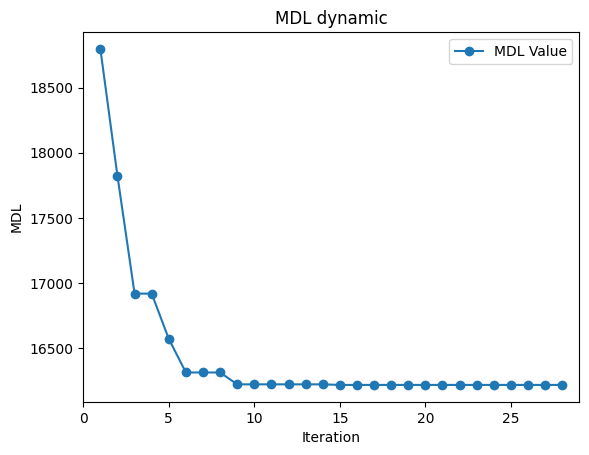

In [24]:
plt.xlim(0, len(MDL) + 1)
plt.plot(range(1, len(MDL) + 1), MDL , marker = "o", label = "MDL Value")
plt.xlabel("Iteration")
plt.ylabel("MDL")
plt.title("MDL dynamic")
plt.legend()
plt.show()

In [25]:
print(Graph_Winners[0])
Etalon_Graph = {"Asia": [],
                "Smoke": [],
                "Tuberculosis":["Asia"],
                "Cancer": ["Smoke"],
                "Bronchitis": ["Smoke"],
                "Tub_or_Cancer": ["Tuberculosis", "Cancer"],
                "X_Ray": ["Tub_or_Cancer"],
                "dyspnea": ["Tub_or_Cancer", "Bronchitis"]
                }
Table, Sum = structural_difference(Etalon_Graph, Graph_Winners[0])
print("Sum:", Sum)
print()
Table

{'Smoke': ['Bronchitis'], 'Cancer': ['Tub_or_Cancer'], 'Tuberculosis': ['Tub_or_Cancer'], 'Tub_or_Cancer': ['X_Ray'], 'Asia': ['Tuberculosis'], 'X_Ray': [], 'Bronchitis': ['dyspnea'], 'dyspnea': ['Tub_or_Cancer']}
Sum: 13



,Etalon Graph Parent Vertices,Built Graph Parent Vertices,Symmetric Difference,Symmetric Difference Card
Vertex,,,,
Asia,[],[Tuberculosis],[Tuberculosis],1
Smoke,[],[Bronchitis],[Bronchitis],1
Tuberculosis,[Asia],[Tub_or_Cancer],"[Tub_or_Cancer, Asia]",2
Cancer,[Smoke],[Tub_or_Cancer],"[Tub_or_Cancer, Smoke]",2
Bronchitis,[Smoke],[dyspnea],"[Smoke, dyspnea]",2
Tub_or_Cancer,"[Tuberculosis, Cancer]",[X_Ray],"[X_Ray, Tuberculosis, Cancer]",3
X_Ray,[Tub_or_Cancer],[],[Tub_or_Cancer],1
dyspnea,"[Tub_or_Cancer, Bronchitis]",[Tub_or_Cancer],[Bronchitis],1


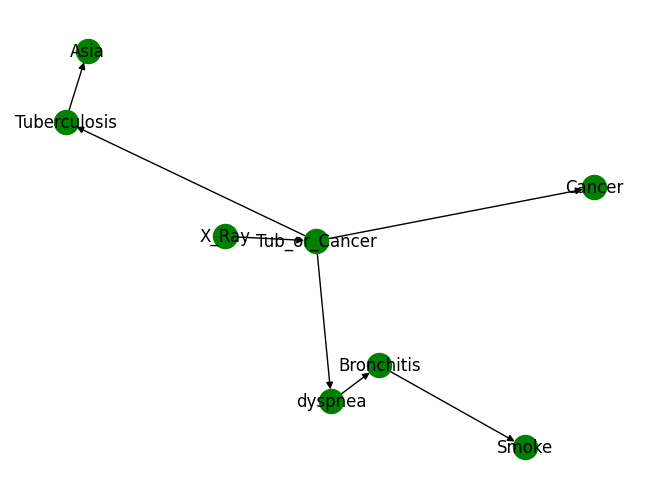

In [32]:
import networkx as nx
G = nx.DiGraph(directed=True)
options = {
    'node_color': 'green'
}
data = pd.read_table("Data/Asia.txt", sep="\t")
G.add_nodes_from(list(data.columns))
for vertex in Graph_Winners[0]:
    for item in Graph_Winners[0][vertex]:
        G.add_edge(item, vertex)

nx.draw(G,with_labels = True, **options)